In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb

In [134]:
import graphviz

In [2]:
penguins = pd.read_csv('penguins_size.csv')
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Note that 'culmen_length_mm' is bill length

In [3]:
penguins.shape

(344, 7)

In [128]:
penguins.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [32]:
# drop any Nans
penguins_clean = penguins[penguins['culmen_length_mm'].notna() & penguins['flipper_length_mm'].notna()]

## Exercuse 9.17

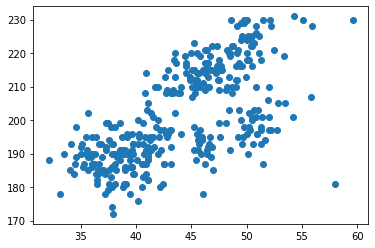

In [33]:
plt.scatter(penguins_clean['culmen_length_mm'],penguins_clean['flipper_length_mm'])

Looks like a linear model IS reasonable

## Exercise 9.16 

Goal is to model the length of flippers by length of the bills.
Problem specifies using weekly informative priors, so we will use bambi which does this automagically.

In [34]:
model = bmb.Model('flipper_length_mm ~ culmen_length_mm', penguins_clean)
model.build()

In [35]:
model

Formula: flipper_length_mm ~ culmen_length_mm
Family name: Gaussian
Link: identity
Observations: 342
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 200.9152, sigma: 284.9837)
    culmen_length_mm ~ Normal(mu: 0.0, sigma: 6.439)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 14.0411)

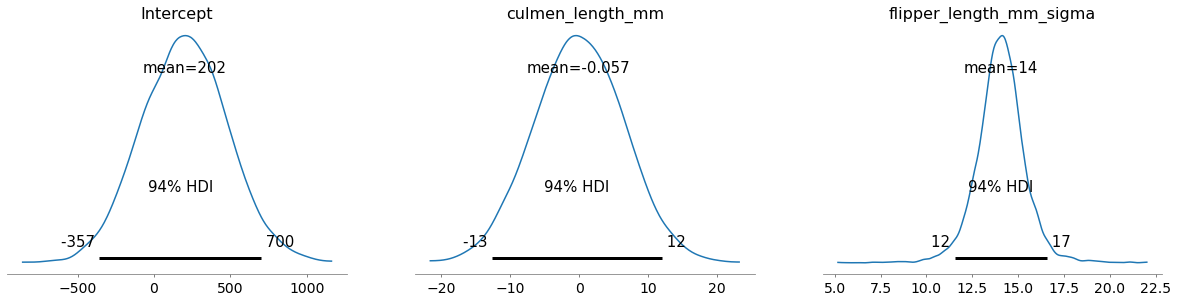

In [36]:
model.plot_priors();

In [37]:
prior_predict = model.prior_predictive(draws = 100 )

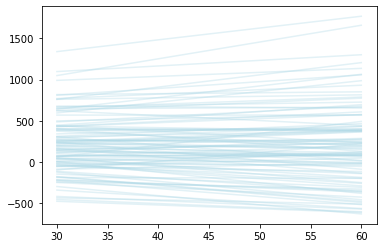

In [104]:
fig, ax= plt.subplots(1,1)
xs = np.linspace(30,60,100)
#ax.scatter(penguins_clean['culmen_length_mm'],penguins_clean['flipper_length_mm'])
for (slope, intercept) in zip(prior_predict.prior.culmen_length_mm.values[0], prior_predict.prior.Intercept.values[0]):
    ax.plot(xs, slope*xs + intercept, color = 'lightblue',alpha = .35)

Simulated data from the PRIORs, seems reasonable. 

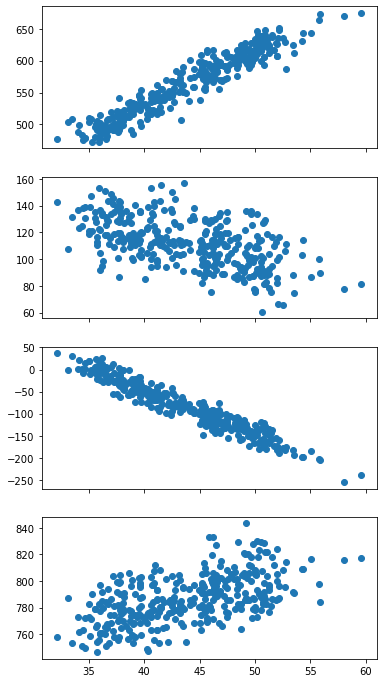

In [105]:
fig, axs= plt.subplots(4,1, sharex = True)
fig.set_size_inches(6,12)
xs = penguins_clean['culmen_length_mm']
i = 0
index = np.random.randint(100-4)
for (slope, intercept, sigma) in zip(prior_predict.prior.culmen_length_mm.values[0][index:index+4],
      prior_predict.prior.Intercept.values[0][index:index+4], prior_predict.prior.flipper_length_mm_sigma.values[0][index:index+4]):
    noise = np.random.normal(0,sigma, size = len(xs))
    axs[i].scatter(xs, slope*xs + intercept+noise)
    i += 1

## Excercise 9.18

In [39]:
result = model.fit(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, culmen_length_mm, flipper_length_mm_sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'culmen_length_mm'}>,
        <AxesSubplot:title={'center':'culmen_length_mm'}>],
       [<AxesSubplot:title={'center':'flipper_length_mm_sigma'}>,
        <AxesSubplot:title={'center':'flipper_length_mm_sigma'}>]],
      dtype=object)

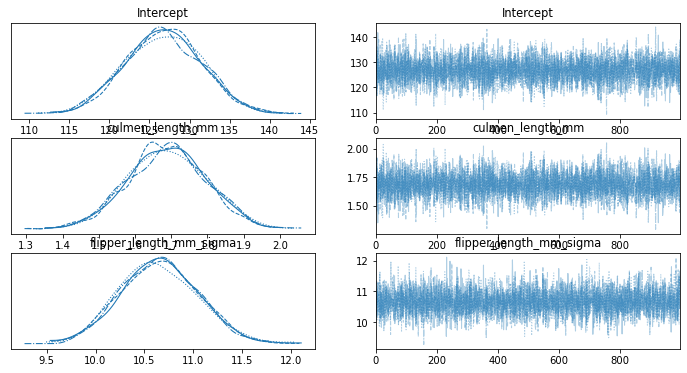

In [40]:
az.plot_trace(result)

100 posterior model lines (using only one chain)

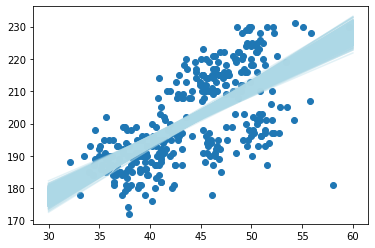

In [106]:
fig, ax= plt.subplots(1,1)
xs = np.linspace(30,60,100)
ax.scatter(penguins_clean['culmen_length_mm'],penguins_clean['flipper_length_mm'])
for (slope, intercept) in zip(result.posterior.culmen_length_mm.values[0],result.posterior.Intercept.values[0]):
    ax.plot(xs, slope*xs + intercept, color = 'lightblue',alpha = .35)

Summary

In [108]:
az.summary(result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,126.742,4.772,117.655,135.445,0.061,0.043,6018.0,2812.0,1.01
culmen_length_mm,1.689,0.108,1.505,1.908,0.001,0.001,6100.0,2797.0,1.01
flipper_length_mm_sigma,10.655,0.401,9.893,11.375,0.005,0.004,6332.0,3120.0,1.00


## Exercise 9.19

First manual method

In [115]:
typical_samples = [slope*51 + intercept for (slope, intercept) in zip(result.posterior.culmen_length_mm.values.flatten(),result.posterior.Intercept.values.flatten())]

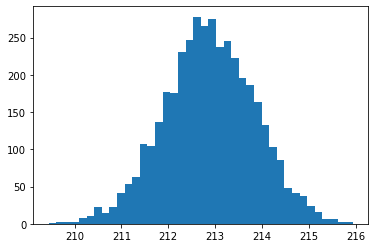

In [122]:
plt.hist(typical_samples,bins=40);

In [130]:
np.quantile(typical_samples,[.05,.95])

array([211.29911826, 214.44973894])

In [123]:
predictive_samples = [slope*51 + intercept + np.random.normal(0,sigma) for (slope, intercept,sigma) in \
     zip(result.posterior.culmen_length_mm.values.flatten(),result.posterior.Intercept.values.flatten(),result.posterior.flipper_length_mm_sigma.values.flatten())]

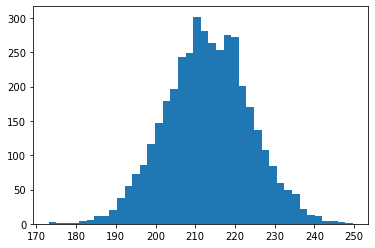

In [124]:
plt.hist(predictive_samples,bins=40);

Note that the exercise calls for density plots, but I dont have seaborn installed here yet.

In [129]:
np.quantile(predictive_samples,[.05,.95])

array([195.4803048 , 230.83500903])

Now we should try to use the posterior prediction capabilities of Bambi

First the 'typical' `kind='mean'` is default. THis adds (in place) a predictive mean to 'result'

In [151]:
model.predict(result, data =pd.DataFrame({'culmen_length_mm':[51]}))

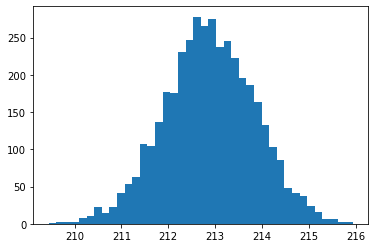

In [152]:
plt.hist(result.posterior.flipper_length_mm_mean.values.flatten(),bins=40);

In [153]:
np.quantile(result.posterior.flipper_length_mm_mean.values.flatten(),[.05,.95])

array([211.29911826, 214.44973894])

Now this adds a posterior predictive group

In [161]:
model.predict(result, kind = 'pps',data =pd.DataFrame({'culmen_length_mm':[51]}))
pp_values = result.posterior_predictive.flipper_length_mm.values.flatten()
np.quantile(pp_values,[.05,.95])

array([195.63135722, 230.12894881])

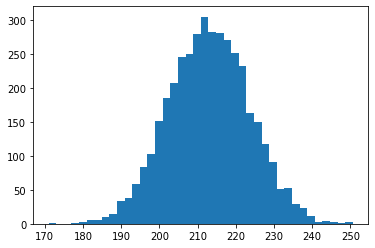

In [162]:
plt.hist(pp_values,bins=40);

SAME answer 